# PCA and SVM Project

http://archive.ics.uci.edu/ml/datasets/statlog+(vehicle+silhouettes)

The purpose of the case study is to classify a given silhouette as one of three different types of
vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from
one of many different angles.
Four "Corgie" model vehicles were used for the experiment: a double-decker bus, Chevrolet
van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was
chosen with the expectation that the bus, van and either one of the cars would be readily
distinguishable, but it would be more difficult to distinguish between the cars.

1. load data
2. check graphs
3. find insigths
4. take some data out for testing
5. fix missing values
6. fix outliers
7. do encoding and other stuff
8. do scaling
9. do pca
10. baseline svm
11. grid search for hyperparams svm
12. find final model
13. build pipeline
14. test on data from step 4

# Load Data and understand

In [1]:
import pandas as pd
import numpy as np

import pandas_profiling as pp

import plotly.express as px
import autoviz as av
import plotly.graph_objects as go


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, StandardScaler

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [2]:
def find_outliers(df):
    col_names = num_cols
    mydata = []
    for col in col_names:
        if col not in target_col:
            try:
                col_data = df[col]
                Q1, Q2, Q3 = np.percentile(col_data, [25, 50, 75])
                IQR = Q3-Q1
                IQR_min = Q1-1.5*IQR
                IQR_max = Q3+1.5*IQR
                ACT_min = col_data.min()
                ACT_max = col_data.max()
                if ((IQR_max < ACT_max)or(IQR_min > ACT_min)):
                    mydata.append(col)
            except:
                continue
    return mydata


def fixoutliers(df):
    outlier_cols = find_outliers(df)
    for col in outlier_cols:
        try:
            col_data = df[col]
            mydata = pd.DataFrame()
            updated = []
            Q1, Q2, Q3 = np.percentile(col_data, [25, 50, 75])
            IQR = Q3-Q1
            minimum = Q1-1.5*IQR
            maximum = Q3+1.5*IQR
            for row_val in col_data:
                if(row_val > maximum):
                    row_val = Q3
                    updated.append(row_val)
                elif(row_val < minimum):
                    row_val = Q21
                    updated.append(row_val)
                else:
                    updated.append(row_val)
            df[col] = updated
        except:
            continue
    return df


def reset_index(dataframe):
    dataframe = dataframe.reset_index(inplace=False)
    return dataframe


get_reset_index = FunctionTransformer(reset_index, validate=False)

In [3]:
df = pd.read_csv('vehicle.csv')

In [4]:
print("Rows     : ", df.shape[0])
print("Columns  : ", df.shape[1])
print("\nFeatures : \n", df.columns.tolist())
print("\nMissing values :  ", df.isnull().sum().values.sum())
print("\nUnique values :  \n", df.nunique())

Rows     :  846
Columns  :  19

Features : 
 ['compactness', 'circularity', 'distance_circularity', 'radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scatter_ratio', 'elongatedness', 'pr.axis_rectangularity', 'max.length_rectangularity', 'scaled_variance', 'scaled_variance.1', 'scaled_radius_of_gyration', 'scaled_radius_of_gyration.1', 'skewness_about', 'skewness_about.1', 'skewness_about.2', 'hollows_ratio', 'class']

Missing values :   41

Unique values :  
 compactness                     44
circularity                     27
distance_circularity            63
radius_ratio                   134
pr.axis_aspect_ratio            37
max.length_aspect_ratio         21
scatter_ratio                  131
elongatedness                   35
pr.axis_rectangularity          13
max.length_rectangularity       66
scaled_variance                128
scaled_variance.1              422
scaled_radius_of_gyration      143
scaled_radius_of_gyration.1     39
skewness_about             

In [5]:
# customer id col
Id_col = ['']
# Target columns
target_col = ["class"]
# categorical columns
cat_cols = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]
# numerical columns
num_cols = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
# Binary columns with 2 values
bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()
# Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]
# customer id col
Id_col = ['']
# Target columns
target_col = ["class"]
# categorical columns
cat_cols = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]
# numerical columns
num_cols = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
# Binary columns with 2 values
bin_cols = df.nunique()[df.nunique() == 2].keys().tolist()
# Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [6]:
df.sample(10)

compactness  circularity  distance_circularity  radius_ratio  \
295           90         38.0                  75.0         164.0   
767           88         39.0                  70.0         166.0   
581           89         36.0                  68.0         141.0   
573           89         47.0                  80.0         131.0   
5            107          NaN                 106.0         172.0   
62            96         40.0                  70.0         120.0   
347           88         44.0                  77.0         167.0   
359          100         49.0                  96.0         206.0   
645           86         44.0                  77.0         155.0   
270           82         45.0                  68.0         150.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
295                  64.0                        7          151.0   
767                  66.0                        7          148.0   
581                  59.0                        8          139.0   
573                  54.0                       11          160.0   
5                    50.0                        6          255.0   
62                   50.0                        8          137.0   
347                  59.0                        6          151.0   
359                  63.0                        9          186.0   
645                  60.0                        7          152.0   
270                  69.0                        5          148.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
295           43.0                    19.0                        131   
767           44.0                    19.0                        134   
581           47.0                    18.0                        130   
573           43.0                    20.0                        163   
5             26.0                    28.0                        169   
62            50.0                    18.0                        141   
347           44.0                    19.0                        145   
359           35.0                    22.0                        156   
645           44.0                    19.0                        141   
270           45.0                    19.0                        144   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
295            168.0              345.0                      139.0   
767            167.0              332.0                      143.0   
581            166.0              291.0                      127.0   
573            175.0              369.0                      174.0   
5              280.0              957.0                      264.0   
62             162.0              269.0                      139.0   
347            175.0              343.0                      177.0   
359            202.0              519.0                      176.0   
645            174.0              345.0                      161.0   
270            169.0              322.0                      184.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
295                         66.0             0.0               0.0   
767                         69.0             5.0              13.0   
581                         73.0             7.0               1.0   
573                         77.0             1.0               7.0   
5                           85.0             5.0               9.0   
62                          80.0            10.0              13.0   
347                         64.0             9.0              12.0   
359                         62.0             3.0               5.0   
645                         72.0             9.0               0.0   
270                         80.0             5.0               0.0   

     skewness_about.2  hollows_ratio class  
295             195.0            204   bus  
767             193.0            201   bus  
581 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

In [8]:
df.describe().transpose()

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0

# EDA,ouliers,missing values

In [9]:
df_new = df.copy()
pp.ProfileReport(df_new)

# Data Visualization

In [10]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


Shape of your Data Set: (846, 19)
Classifying variables in data set...
    18 Predictors classified...
        This does not include the Target column(s)
    No variables removed since no ID or low-information variables found in data set
Total Number of Scatter Plots = 21
Number of Cat and Continuous Vars exceeds 30, hence no Pivot or Bar Charts
Time to run AutoViz (in seconds) = 7.988


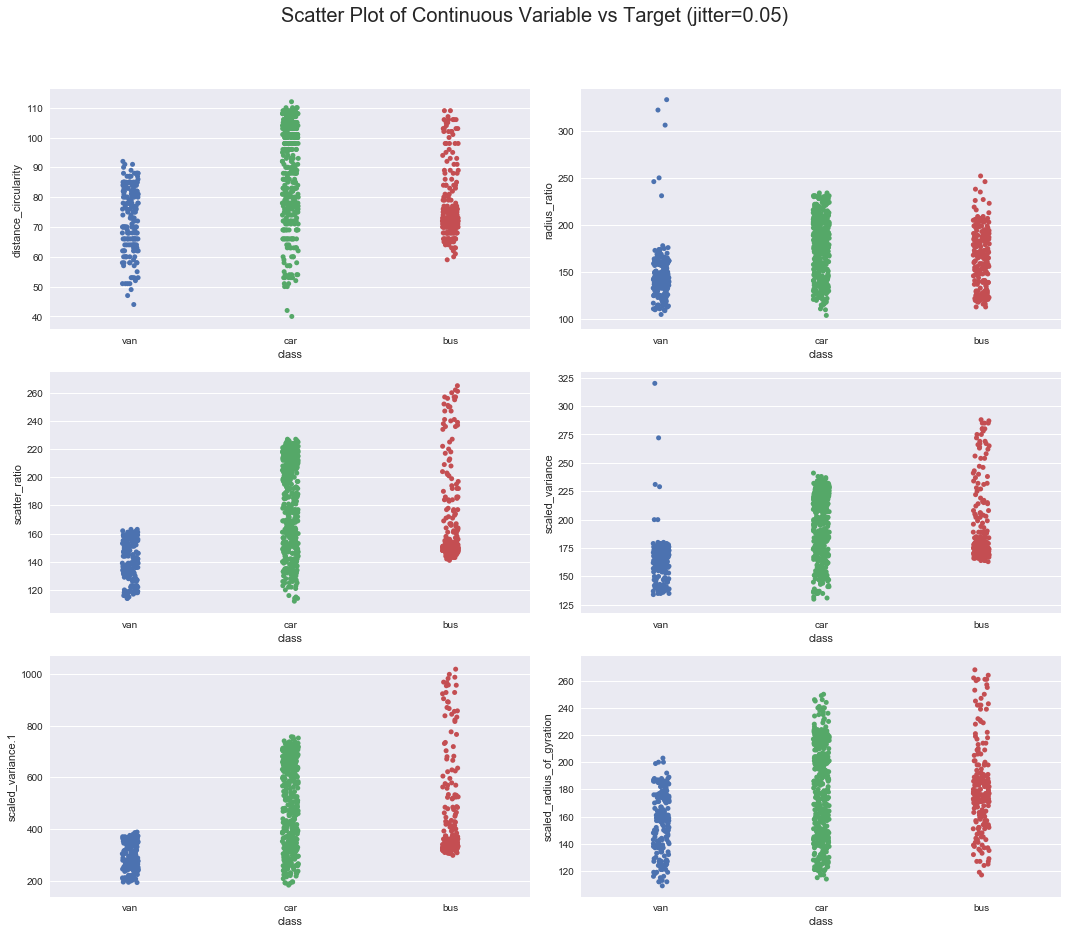

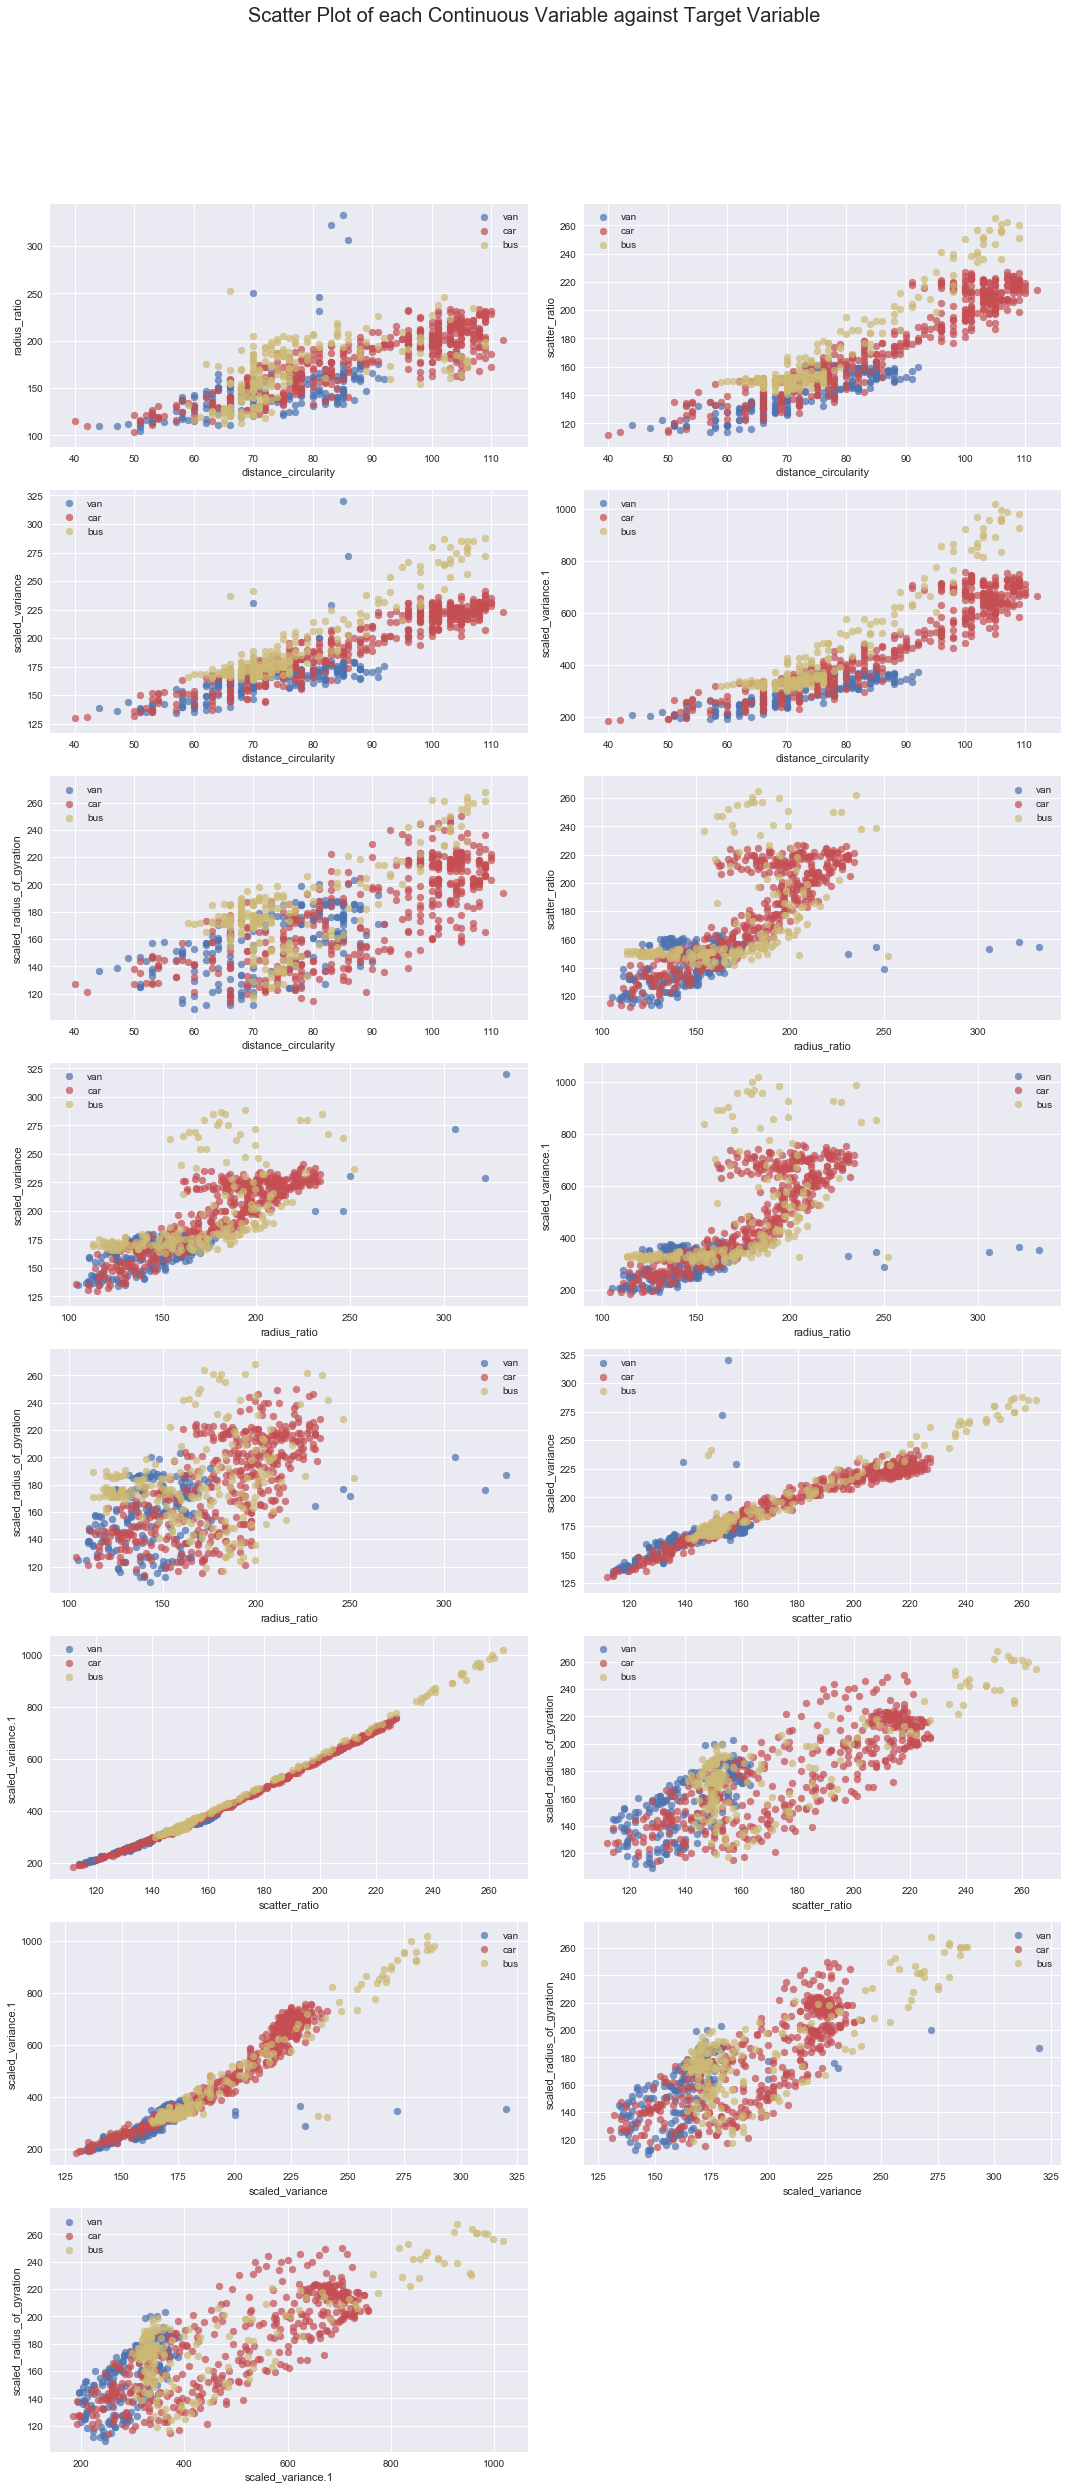

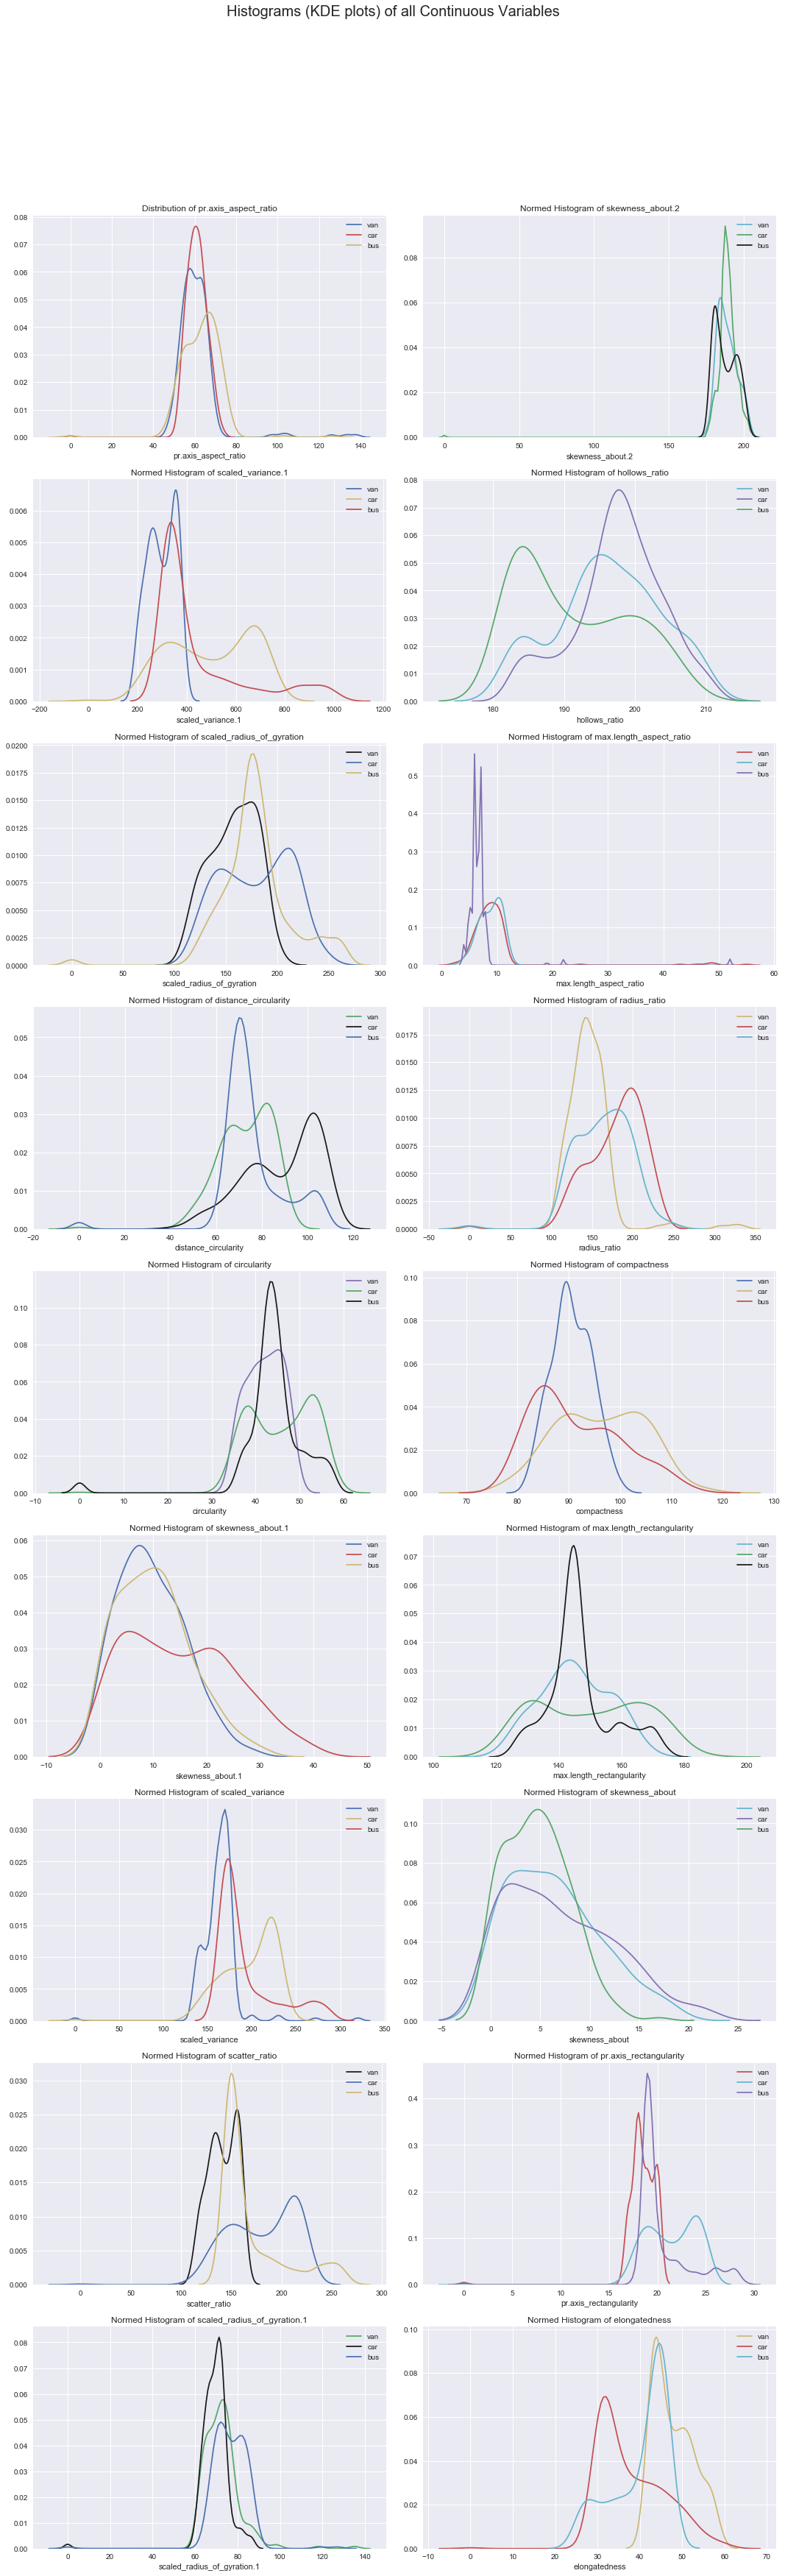

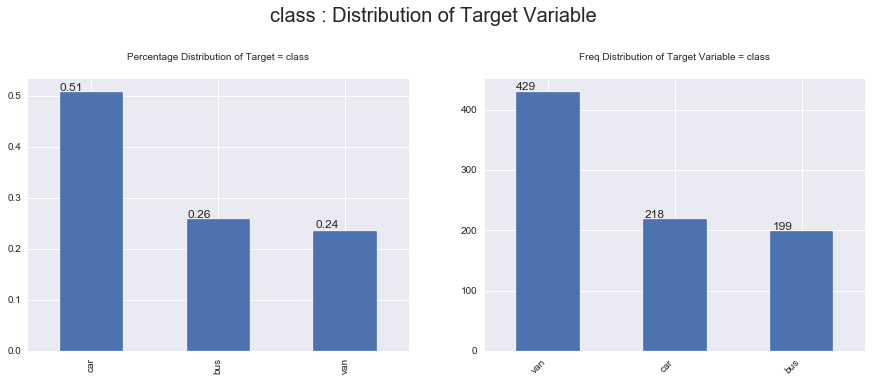

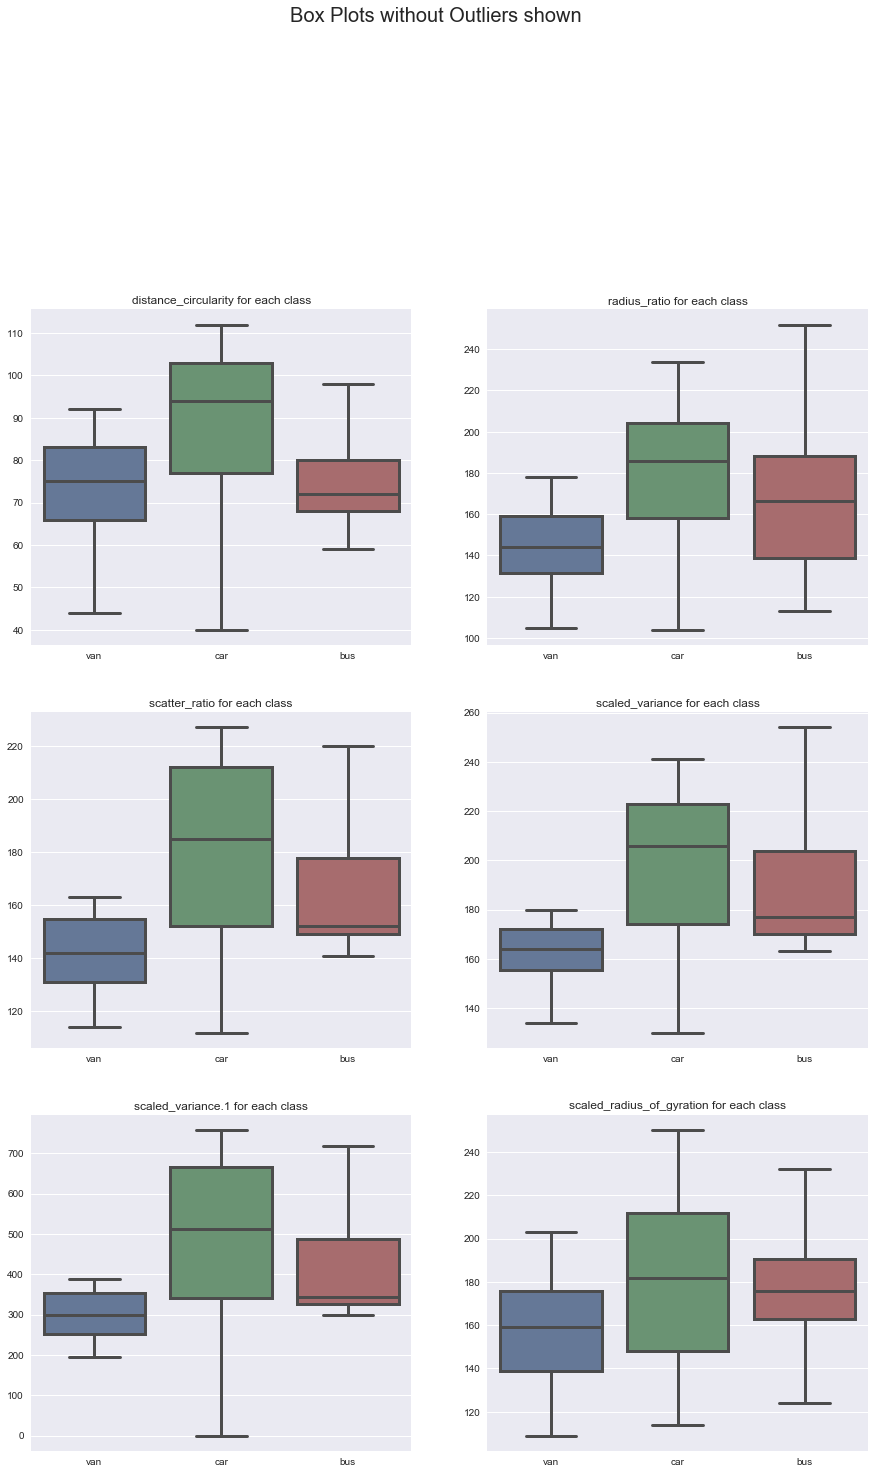

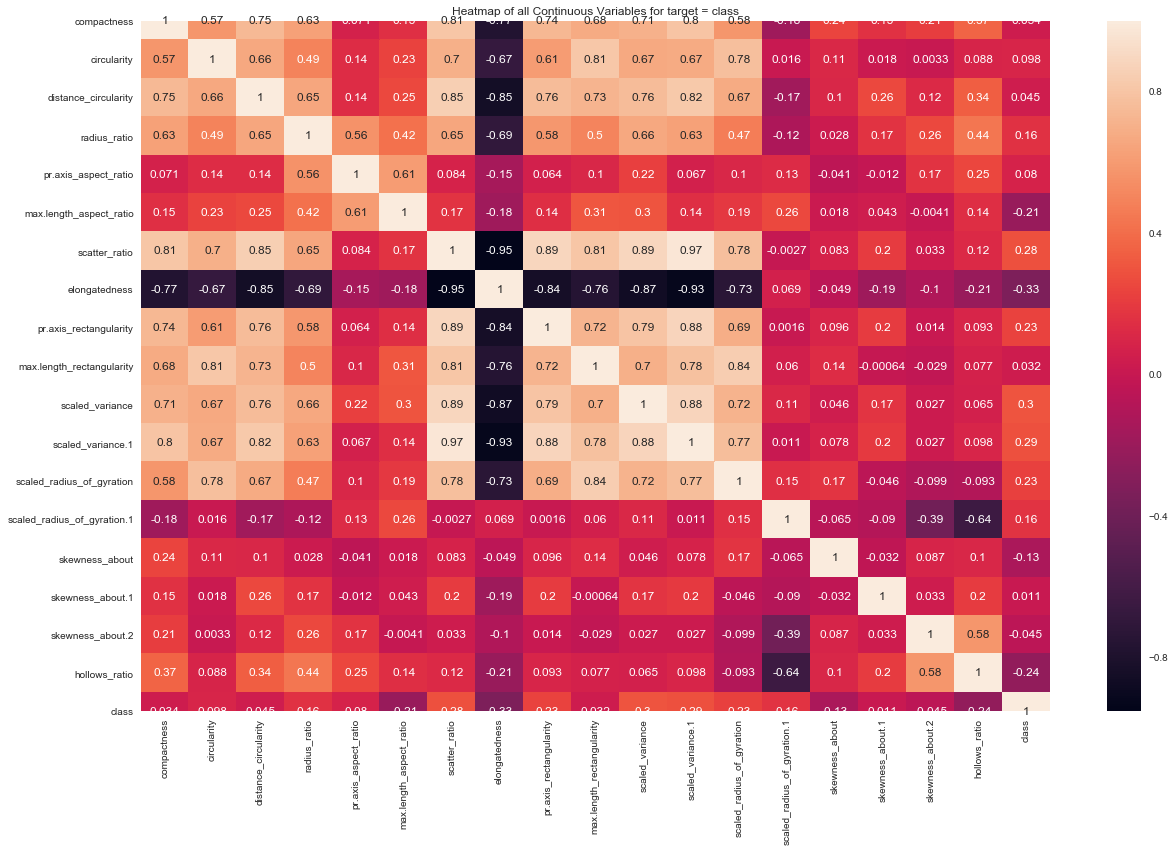

In [11]:
filename = ""
sep = ","
dft = AV.AutoViz(
    '',
    ',',
    'class',
    df,
    header=0,
    verbose=0,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)

In [12]:
def plot_box(column):
    fig = px.box(data_frame=df, y=column)
    fig.show()

for x in df.columns:
    plot_box(x)

## Insights from data visuals

# Preprocessing

## label encode target column

In [13]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

## take some data out as your production data

In [14]:
prod_data = df.sample(frac=.2)
df.drop(index=prod_data.index, axis=0, inplace=True)
df.shape

(677, 19)

## Fix missing Values

In [15]:
imputer = SimpleImputer(strategy='median')
df = imputer.fit_transform(df)

In [16]:
df = pd.DataFrame(df, columns=num_cols+target_col)
df

compactness  circularity  distance_circularity  radius_ratio  \
0           95.0         48.0                  83.0         178.0   
1           91.0         41.0                  84.0         141.0   
2           93.0         41.0                  82.0         159.0   
3           85.0         44.0                  70.0         205.0   
4          107.0         44.0                 106.0         172.0   
..           ...          ...                   ...           ...   
672         90.0         44.0                  72.0         157.0   
673         93.0         34.0                  66.0         140.0   
674         93.0         39.0                  87.0         183.0   
675         89.0         46.0                  84.0         163.0   
676         85.0         36.0                  66.0         123.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                    72.0                     10.0          162.0   
1                    57.0                      9.0          149.0   
2                    63.0                      9.0          144.0   
3                   103.0                     52.0          149.0   
4                    50.0                      6.0          255.0   
..                    ...                      ...            ...   
672                  64.0                      8.0          137.0   
673                  56.0                      7.0          130.0   
674                  64.0                      8.0          169.0   
675                  66.0                     11.0          159.0   
676                  55.0                      5.0          120.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0             42.0                    20.0                      159.0   
1             45.0                    19.0                      143.0   
2             46.0                    19.0                      143.0   
3             45.0                    19.0                      144.0   
4             26.0                    28.0                      169.0   
..             ...                     ...                        ...   
672           48.0                    18.0                      144.0   
673           51.0                    18.0                      120.0   
674           40.0                    20.0                      134.0   
675           43.0                    20.0                      159.0   
676           56.0                    17.0                      128.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0              176.0              379.0                      184.0   
1              170.0              330.0                      158.0   
2              160.0              309.0                      127.0   
3              241.0              325.0                      188.0   
4              280.0              957.0                      264.0   
..               ...                ...                        ...   
672            159.0              283.0                      171.0   
673            151.0              251.0                      114.0   
674            200.0              422.0                      149.0   
675            173.0              368.0                      176.0   
676            140.0              212.0                      131.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                           70.0             6.0              16.0   
1                           72.0             9.0              14.0   
2                           63.0             6.0              10.0   
3                          127.0             9.0              11.0   
4                           85.0             5.0               9.0   
..                           ...             ...               ...   
672                         65.0             9.0               4.0   
673                         62.0             5.0              29.0   

## fix outliers

In [17]:
df = fixoutliers(df)

## Validate if outliers are fixed

In [18]:
for x in find_outliers(df):
    plot_box(x)

In [19]:
outlier_cols = find_outliers(df)
outlier_cols

['max.length_aspect_ratio']

## split X and y

In [20]:
X = df.drop(labels='class', axis=1)
y = df["class"]

In [21]:
df.corr()['class']

compactness                   -0.021638
circularity                   -0.137489
distance_circularity          -0.043723
radius_ratio                  -0.206798
pr.axis_aspect_ratio          -0.219561
max.length_aspect_ratio        0.216417
scatter_ratio                 -0.270622
elongatedness                  0.327910
pr.axis_rectangularity        -0.236159
max.length_rectangularity     -0.007973
scaled_variance               -0.304362
scaled_variance.1             -0.264849
scaled_radius_of_gyration     -0.236924
scaled_radius_of_gyration.1   -0.271797
skewness_about                 0.127553
skewness_about.1               0.003743
skewness_about.2               0.048820
hollows_ratio                  0.223146
class                          1.000000
Name: class, dtype: float64

## center the data

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# PCA

In [23]:
pca_data = pd.DataFrame([[0, 0, 0]], columns=[
                        'n_components', 'Cumulative_Variance', 'individual_variance'])
for k in range(1, 18):
    pca = PCA(n_components=k)
    pca.fit(X)
    cum_var = sum(pca.explained_variance_ratio_)
    ind_var = pca.explained_variance_ratio_
    row = pd.DataFrame(data=[[k, cum_var, ind_var]], columns=[
                       'n_components', 'Cumulative_Variance', 'individual_variance'])
    pca_data = pca_data.append(row, ignore_index=True)
pca_data

n_components  Cumulative_Variance  \
0              0             0.000000   
1              1             0.521928   
2              2             0.705167   
3              3             0.771171   
4              4             0.835899   
5              5             0.891048   
6              6             0.931413   
7              7             0.957423   
8              8             0.969921   
9              9             0.979483   
10            10             0.985337   
11            11             0.989407   
12            12             0.992478   
13            13             0.994426   
14            14             0.996235   
15            15             0.997511   
16            16             0.998720   
17            17             0.999702   

                                  individual_variance  
0                                                   0  
1                                [0.5219282854144135]  
2           [0.5219282854144129, 0.18323830297952085]  
3   [0.5219282854144128, 0.18323830297952018, 0.06...  
4   [0.5219282854144126, 0.18323830297952085, 0.06...  
5   [0.5219282854144132, 0.1832383029795204, 0.066...  
6   [0.5219282854144126, 0.18323830297952076, 0.06...  
7   [0.5219282854144128, 0.18323830297952098, 0.06...  
8   [0.5219282854144129, 0.18323830297952048, 0.06...  
9   [0.5219282854144135, 0.18323830297952062, 0.06...  
10  [0.5219282854144129, 0.1832383029795204, 0.066...  
11  [0.5219282854144135, 0.18323830297952048, 0.06...  
12  [0.5219282854144129, 0.18323830297952062, 0.06...  
13  [0.5219282854144135, 0.1832383029795204, 0.066...  
14  [0.5219282854144132, 0.1832383029795204, 0.066...  
15  [0.5219282854144136, 0.18323830297952057, 0.06...  
16  [0.5219282854144136, 0.18323830297952057, 0.06...  
17  [0.5219282854144136, 0.18323830297952057, 0.06...

In [24]:
# elbow plot
trace1 = {
    "type": "scatter",
    "x": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "y": pca_data.Cumulative_Variance
}
layout = {
    "title": "Elbow Plot for best value in PCA",
    "xaxis": {"title": "n_components"},
    "yaxis": {"title": "cumulative variance"}
}
fig = go.Figure(trace1, layout=layout)
fig.show()

In [25]:
pca = PCA(n_components=7, random_state=1)
pca.fit(X)
X_pca = pca.transform(X)
eig_vals = pca.explained_variance_ratio_
tot = 100
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = dict(
    type='bar',
    x=['PC %s' % i for i in range(1, 8)],
    y=var_exp,
    name='Individual'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' % i for i in range(1, 8)],
    y=cum_var_exp,
    name='Cumulative'
)

data = [trace1, trace2]

layout = dict(
    title='Explained variance by different principal components',
    yaxis=dict(
        title='Explained variance in percent'
    ),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='Explained Variance',
            showarrow=False,
        )
    ])
)

fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='selecting-principal-components')
fig.show()

# SVM

## svm baseline model

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.2)

In [27]:
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
print('train accuracy is: ', accuracy_score(y_train, clf.predict(X_train)))

train accuracy is:  0.9186691312384473


In [29]:
print('test accuracy is: ', accuracy_score(y_test, clf.predict(X_test)))

test accuracy is:  0.8970588235294118


In [30]:
confusion_matrix(y_test, clf.predict(X_test))

array([[31,  1,  0],
       [ 1, 63,  6],
       [ 1,  5, 28]], dtype=int64)

In [31]:
print('f1 score is: ', f1_score(y_test, clf.predict(X_test), average='micro'))

f1 score is:  0.8970588235294118


## svm hyperparameters tuning and grid search

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.2, stratify=y
                                                    )
parameters = {'kernel': ('linear', 'rbf'), 'C': [0.01, 0.05, 0.5, 1]}
clf = SVC()
clf = GridSearchCV(SVC(), parameters)
clf.fit(X_train, y_train)
print(clf.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## SVM final model and accuracy scores etc..

In [33]:
print(clf.score(X_train,y_train))

0.922365988909427


In [34]:
print(clf.score(X_test,y_test))

0.8897058823529411


# Make Pipeline 

In [35]:
# steps to be compbined are
# 1. imputer=SimpleImputer(strategy='median')
#    fix outliers
# 2. scaler = StandardScaler()
# 3. pca = PCA(n_components=7)
# 4. clf = SVC(C=1,  kernel='rbf',random_state=1)

In [41]:
df = pd.read_csv('vehicle.csv')
prod_data = df.sample(frac=.2)
df.drop(index=prod_data.index, axis=0, inplace=True)

In [42]:
imputer = SimpleImputer(strategy='median')
fixoutliers_pipe = FunctionTransformer(fixoutliers, validate=False)
scaler = StandardScaler()
pca = PCA(n_components=7, random_state=1)
clf = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
          max_iter=-1, probability=False, random_state=1, shrinking=True,
          tol=0.001, verbose=False)

In [43]:
pl = Pipeline(memory=None,
              steps=[
                  ('reset_index', get_reset_index),
                  ('imputer', imputer),
                  ('fixoutliers_pipe', fixoutliers_pipe),
                  ('scaler', scaler),
                  ('pca', pca),
                  ('SVM', clf)
              ], verbose=False)

In [44]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
X = df.drop(labels='class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y
                                                    )
pl.fit(X_train, y_train)
print('test accuracy', pl.score(X_test, y_test))
print('train accuracy', pl.score(X_train, y_train))

test accuracy 0.8529411764705882
train accuracy 0.9168207024029574


In [45]:
# now the biggest challenge on unseen data
prod_data['class'] = label_encoder.fit_transform(prod_data['class'])
X_prod = prod_data.drop(labels='class', axis=1)
y_prod = prod_data['class']
y_pred = pl.predict(X_prod)
print('unseen data accuracy', accuracy_score(y_prod, y_pred))

unseen data accuracy 0.8698224852071006
